# Brief [To be updated]
Beta Bank customers are leaving: little by little, chipping away every month. Bankers have figured out it’s cheaper to save the existing customers rather than to attract new ones.


# Data

- `RowNumber`: data string index


- `CustomerId`: unique customer identifier


- `Surname`: surname


- `CreditScore`: credit score


- `Geography`: country of residence


- `Gender`: gender


- `Age`: age


- `Tenure`: period of maturation for a customer’s fixed deposit (years)


- `Balance`: account balance


- `NumOfProducts`: number of banking products used by the customer


- `HasCrCard`: customer has a credit card


- `IsActiveMember`: customer’s activeness


- `EstimatedSalary`: estimated salary


- `Exited`: сustomer has left, "yes" — 1, "no" — 0

# Task

Build a model with the maximum possible F1 score to predict whether a customer will leave the bank soon. Our target F1 score of at least 0.59.

   - Additionally, measure the ROC-AUC metric and compare it with the F1.

**Libraries**

Common

In [1345]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Sklearn

In [1346]:
from sklearn.metrics import accuracy_score, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

Other

In [1347]:
from collections import Counter
from imblearn.over_sampling import SMOTE

**Data**

In [1348]:
try: 
    df = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/Supervised Learning/Churn.csv')
except:
    print('There is an error with your path.')

Dtypes

In [1349]:
print("The DataFrame's structure:")
print('')
df.info()

The DataFrame's structure:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


`Findings`

- Data types seem largely okay. Floats, excluding EstimatedSalary, can be converted to Integers and both Geography/Gender can be converted to Category type. 


- We notice missing values from our Tenure feature, depending on the proportion we will either remove or impute.

In [1350]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [1351]:
df.duplicated().sum()

0

In [1352]:
df.nunique().sort_values(ascending=False)

RowNumber          10000
CustomerId         10000
EstimatedSalary     9999
Balance             6382
Surname             2932
CreditScore          460
Age                   70
Tenure                11
NumOfProducts          4
Geography              3
Gender                 2
HasCrCard              2
IsActiveMember         2
Exited                 2
dtype: int64

In [1353]:
df_miss = (df.isnull().sum() / len(df)) * 100
df_miss = df_miss.drop(df_miss[df_miss == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_miss})
missing_data.head(10)

,Missing Ratio
Tenure,9.09


In [1354]:
df.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [1355]:
print("The DataFrame's statistical data:")
df.describe()

The DataFrame's statistical data:


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [1356]:
display(df.sample(10))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4260,4261,15664555,Hughes,587,France,Male,40,NaN,0.00,4,0,1,106174.70,1
5296,5297,15702462,Fiorentini,619,Spain,Female,44,6.0,52831.13,1,1,1,112649.22,1
4691,4692,15758050,Madukwe,622,Spain,Male,37,4.0,0.00,2,1,0,4459.50,0
8348,8349,15796230,Morley,642,Germany,Female,36,2.0,124495.98,3,1,1,57904.22,1
2848,2849,15713608,Tuan,850,France,Female,41,5.0,0.00,2,1,1,34827.43,0
1457,1458,15590320,Shelton,850,France,Male,66,4.0,0.00,2,0,1,64350.80,0
8396,8397,15655082,Pape,607,France,Female,48,4.0,112070.86,3,1,0,173568.30,1
9200,9201,15567923,Barese,739,France,Female,30,6.0,0.00,1,0,0,122604.44,0
2400,2401,15607827,Nebechukwu,711,Germany,Male,34,4.0,133467.77,2,1,1,42976.64,0
1578,1579,15585047,Onyemere,715,France,Male,28,7.0,160376.61,1,0,0,196853.11,0


Feature Review

In [1357]:
# function to classify features
def classify_features(df):
    """Feature classification function.
    Assigns features to certain variables to review categorization across the dataset's features.
    """
    categorical_features = []
    non_categorical_features = []
    discrete_features = []
    continuous_features = []

    for column in df.columns:
        if df[column].dtype in ['object', 'bool', 'category']: 
            if df[column].nunique() < 15:
                categorical_features.append(column)
            else: 
                non_categorical_features.append(column)
        elif df[column].dtype in ['int64', 'float64']:
            if df[column].nunique() < 10:
                discrete_features.append(column)
            else: 
                continuous_features.append(column)
    return categorical_features, non_categorical_features, discrete_features, continuous_features

In [1358]:
categorical, non_categorical, discrete, continuous = classify_features(df)

In [1359]:
print("Categorical Features:", categorical)
print("Non-Categorical Features:", non_categorical)
print("Discrete Features:", discrete)
print("Continuous Features:", continuous)

Categorical Features: ['Geography', 'Gender']
Non-Categorical Features: ['Surname']
Discrete Features: ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
Continuous Features: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


In [1360]:
for i in categorical:
    #print(i, ':')
    print(df[i].value_counts())
    print()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Gender
Male      5457
Female    4543
Name: count, dtype: int64


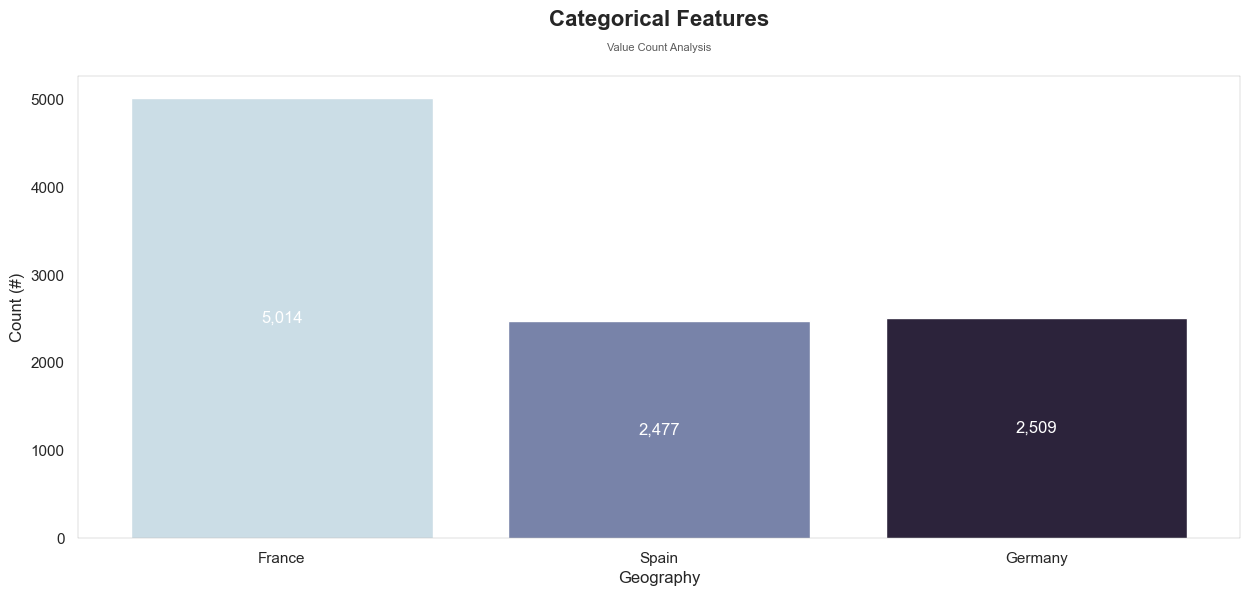

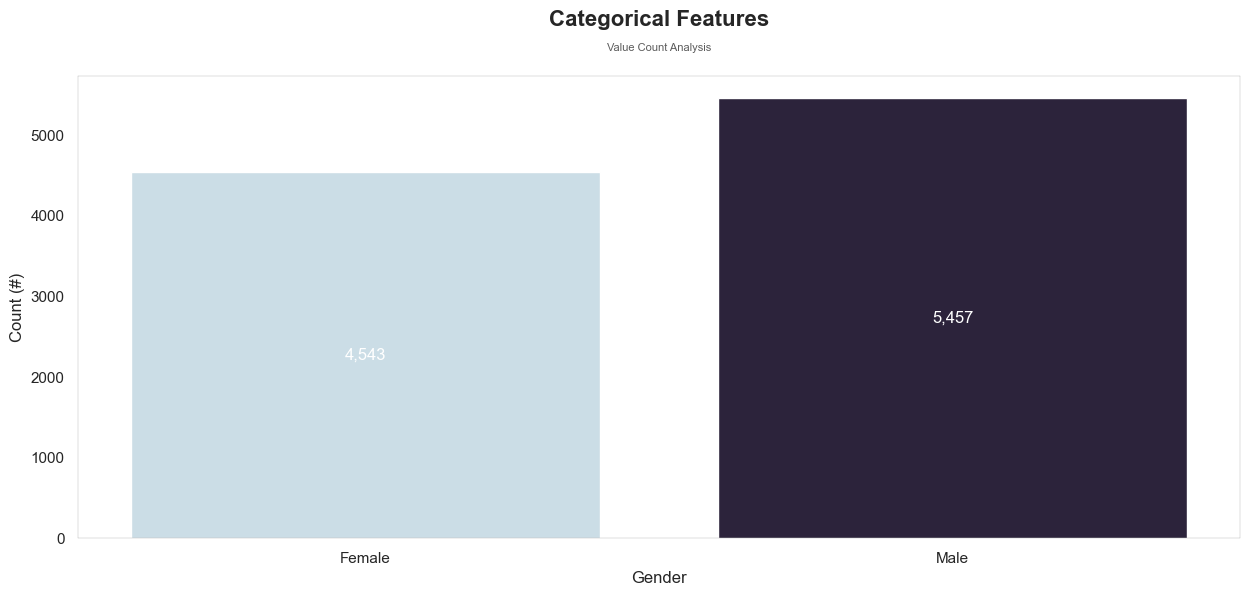

In [1361]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

for i in categorical:
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.countplot(x=i, data=df, palette="ch:s=.25,rot=-.25", hue=i, ax=ax)
    ax.relim()  # the plot limits need to be updated with the moved bars
    ax.autoscale()
    ax.text(x=0.5, y=1.1, s='Categorical Features', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    ax.text(x=0.5, y=1.05, s='Value Count Analysis', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
    ax.set(ylabel='Count (#)')
    plt.xticks(rotation = None)
    bottoms = {}
    for bars in ax.containers:
        for bar in bars:
            x, y = bar.get_xy()
            h = bar.get_height()
            if x in bottoms:
                bar.set_y(bottoms[x])
                bottoms[x] += h
            else:
                bottoms[x] = h

    for c in ax.containers:
        labels = [f'{round((v.get_height())):,}' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', color='white')

    plt.show()

In [1362]:
for i in non_categorical:
    #print(i, ':')
    print(df[i].value_counts())
    print()

Surname
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: count, Length: 2932, dtype: int64


In [1363]:
for i in discrete:
    #print(i, ':')
    print(df[i].value_counts())
    print()

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

HasCrCard
1    7055
0    2945
Name: count, dtype: int64

IsActiveMember
1    5151
0    4849
Name: count, dtype: int64

Exited
0    7963
1    2037
Name: count, dtype: int64


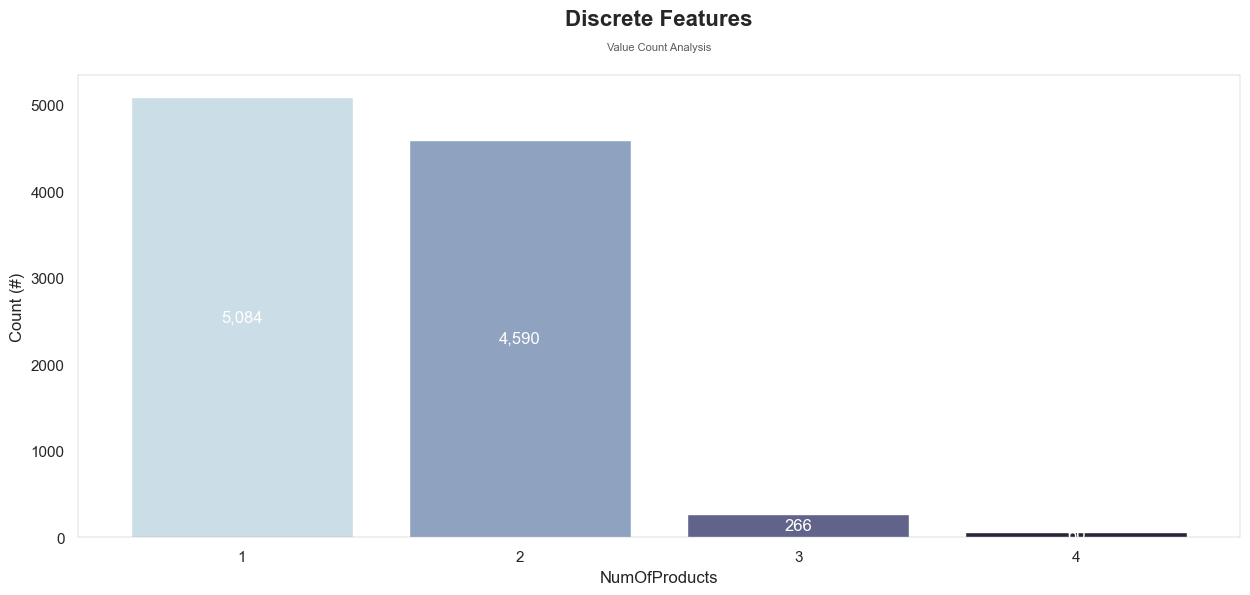

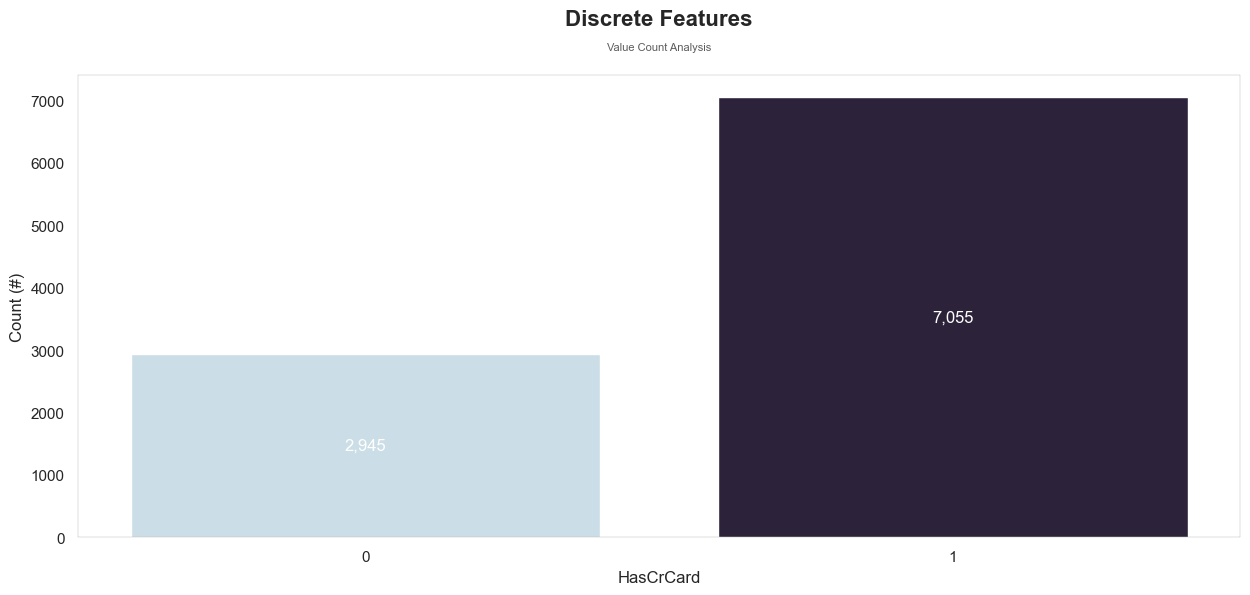

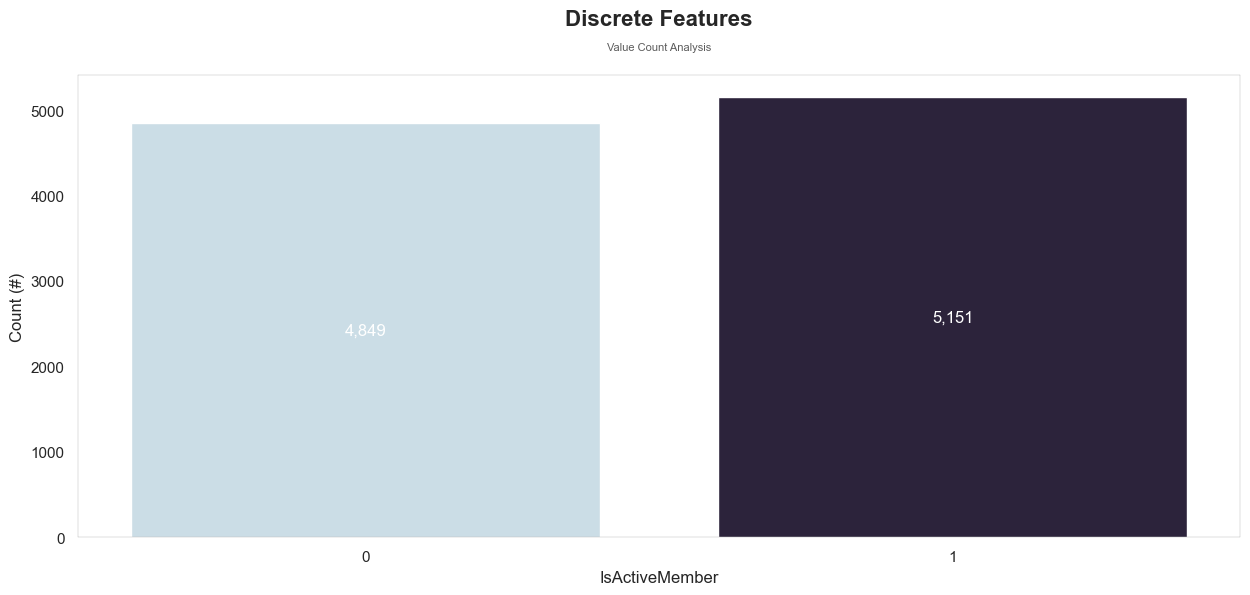

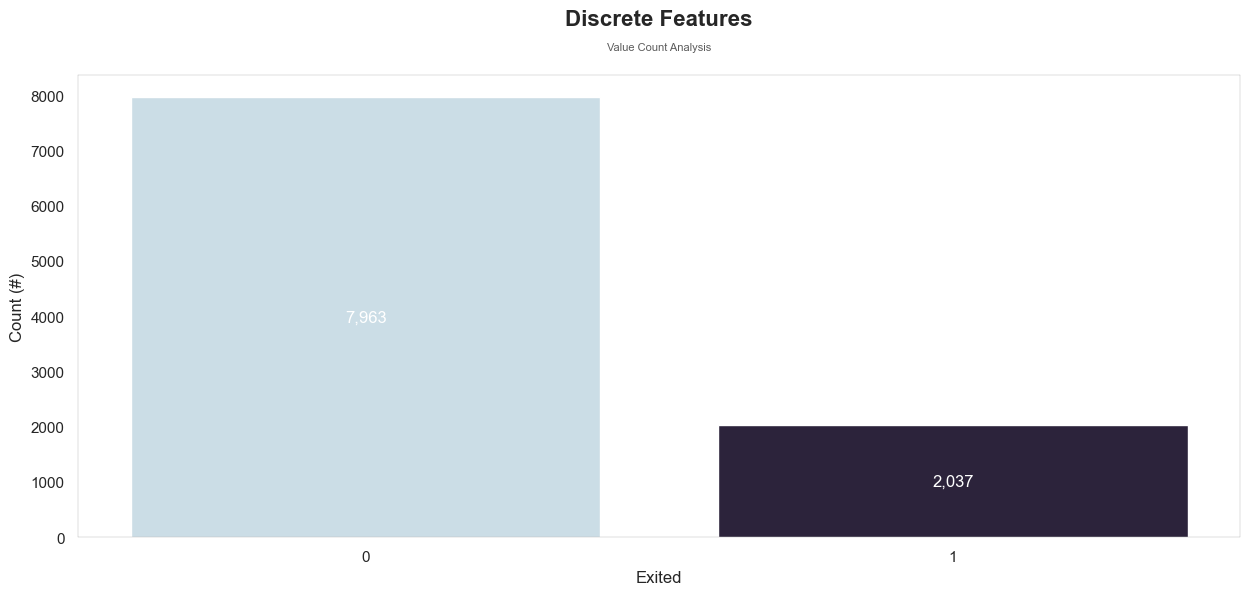

In [1364]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

for i in discrete:
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.countplot(x=i, data=df, palette="ch:s=.25,rot=-.25", hue=i, ax=ax, legend=None)
    ax.relim()  # the plot limits need to be updated with the moved bars
    ax.autoscale()
    ax.text(x=0.5, y=1.1, s='Discrete Features', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    ax.text(x=0.5, y=1.05, s='Value Count Analysis', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
    ax.set(ylabel='Count (#)')
    plt.xticks(rotation = None)
    bottoms = {}
    for bars in ax.containers:
        for bar in bars:
            x, y = bar.get_xy()
            h = bar.get_height()
            if x in bottoms:
                bar.set_y(bottoms[x])
                bottoms[x] += h
            else:
                bottoms[x] = h

    for c in ax.containers:
        labels = [f'{round((v.get_height())):,}' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', color='white')

    plt.show()

Grouping Insights

In [1365]:
# dictionary expression
dict_agg = {'count': ['HasCrCard'], 'mean': ['CreditScore', 'Balance', 'NumOfProducts', 'Tenure', 'EstimatedSalary']}
# grouping table
df_group = df.groupby(['Geography','Gender']).agg({k: v for v,l in dict_agg.items() for k in l})
display(df_group)

HasCrCard  CreditScore        Balance  NumOfProducts  \
Geography Gender                                                         
France    Female       2261   649.185759   60322.670159       1.547545   
          Male         2753   650.064657   63546.284875       1.517254   
Germany   Female       1193   653.093881  119145.966471       1.511316   
          Male         1316   649.966565  120259.668222       1.527356   
Spain     Female       1089   651.769513   59862.092534       1.573003   
          Male         1388   650.992075   63352.833746       1.512968   

                    Tenure  EstimatedSalary  
Geography Gender                             
France    Female  4.943249     99564.252755  
          Male    5.053472    100174.252495  
Germany   Female  4.952074    102446.424124  
          Male    5.007450     99905.033959  
Spain     Female  4.992915    100734.107475  
          Male    5.008730     98425.687680

`Findings`

- Our missing values from the Tenure feature account for about 9% as a proportion of the total. Given this is above 5% (our removal threshold), we will impute the values using the mean.
    
- Can perceive imbalance from our target feature (a considerable delta).

- Given differences in values across the dataset, we will have to deploy some encoding and perhaps scaling in order to preprocess the data and get it in the best shape possible for our modeling.

- Grouping some of the features gives us some insights into the relationships between Gender and Geography. We see males having more credit cards throughout in tandem with higher account balances. There seems to be slightly lower average credit scores as well as estimated salaries (with the exception of France) for males. 
    - There is less variation with the average number of products and tenure, hovering around 1.5 for the number of products and about 5 years of tenure across the groupings.
    

Feature removal

In [1366]:
# we're removing rows that, at first glance, don't seem to have any significance and may possible introduce more noise
df = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)

display(df)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Imbalance

Checking frequency:
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


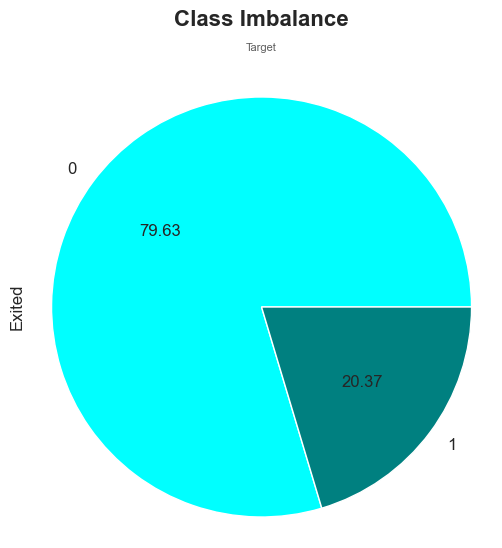

In [1367]:
class_frequency = df['Exited'].value_counts(normalize=True) #normalizing from 0 to 1
print('Checking frequency:')
print(class_frequency)

sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(15, 6))
class_frequency.plot.pie(autopct='%.2f',textprops={'fontsize':12}, colors=['cyan', 'teal'], ylabel='Exited')
ax.autoscale()
ax.text(x=0.5, y=1.1, s='Class Imbalance', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Target', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
# ax.set(ylabel='Count (#)')

plt.show()

**Encoding and Scaling**

In [1368]:
encoder = LabelEncoder() 

In [1369]:
# to bypass limitations and encode multiple columns
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # column names to encode

    def fit(self,X,y=None):
        return self 

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [1370]:
df = MultiColumnLabelEncoder(columns = ['Geography','Gender']).fit_transform(df)

In [1371]:
# imputation
df['Tenure'].fillna(value=df['Tenure'].mean(), inplace=True)

In [1372]:
X = df.drop('Exited', axis=1).values
y = df['Exited'].values

Sampling

In [1398]:
smote = SMOTE()

# fitting predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)
print('Resample dataset shape:', Counter(y_smote))
print('Feature shape comparison:', (X.shape, x_smote.shape))

Resample dataset shape: Counter({1: 7963, 0: 7963})
Feature shape comparison: ((10000, 10), (15926, 10))


Reproducibility

In [1374]:
seed = 12345

RepeatedStratifiedKFold

In [1375]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

In [1376]:
X_train, X_test, y_train, y_test = train_test_split(x_smote,
                                                    y_smote,
                                                    test_size=0.2,
                                                    random_state=seed)
# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Classifiers

In [1377]:
dt = DecisionTreeClassifier(random_state=seed)
rf = RandomForestClassifier(random_state=seed)

classifiers = [('Decision Tree', dt), ('Random Forest', rf)]

In [1378]:
for clf_name, clf in classifiers:
    # fit the training set
    clf.fit(X_train_scaled, y_train)

    # label prediction
    y_pred = clf.predict(X_test_scaled)

    # evaluations
    cv = cross_val_score(clf, x_smote, y_smote, scoring='f1', cv=rskf, n_jobs=-1)
    print('{} Average Cross-Val Score w/F-1 scoring: {:.3f}'.format(clf_name, cv.mean()))


Decision Tree Average Cross-Val Score w/F-1 scoring: 0.863
Random Forest Average Cross-Val Score w/F-1 scoring: 0.907


Voting

In [1379]:
vc = VotingClassifier(estimators=classifiers)

# fit and predict
vc.fit(X_train_scaled, y_train)
y_pred = vc.predict(X_test_scaled)

# evaluation
cv = cross_val_score(vc, x_smote, y_smote, scoring='f1', cv=rskf, n_jobs=-1)

print('Average Cross-Val Score w/F-1 scoring: {:.3f}'.format(cv.mean()))

Average Cross-Val Score w/F-1 scoring: 0.892


Bagging

In [1380]:
bc = BaggingClassifier(estimator=dt, random_state=seed)

bc.fit(X_train_scaled, y_train)

y_pred = bc.predict(X_test_scaled)
y_pred_proba = bc.predict_proba(X_test_scaled)[:, 1]

# evaluation
cv = cross_val_score(bc, x_smote, y_smote, scoring='f1', cv=rskf, n_jobs=-1)

print('Average Cross-Val Score w/F-1 scoring: {:.3f}'.format(cv.mean()))

Average Cross-Val Score w/F-1 scoring: 0.896


AdaBoost

In [1381]:
ada = AdaBoostClassifier(estimator=rf, random_state=seed, algorithm = 'SAMME') # algo. 'SAMME.R' is being deprecated

ada.fit(X_train_scaled, y_train)

y_pred = ada.predict(X_test_scaled)
y_pred_proba = ada.predict_proba(X_test_scaled)[:, 1]

# evaluation
cv = cross_val_score(ada, x_smote, y_smote, scoring='f1', cv=rskf, n_jobs=-1)

print('Average Cross-Val Score w/F-1 scoring: {:.3f}'.format(cv.mean()))

Average Cross-Val Score w/F-1 scoring: 0.907


Gradient Boosting

In [1382]:
sgbt = GradientBoostingClassifier(random_state=seed)

sgbt.fit(X_train_scaled, y_train)

y_pred_sgbt = sgbt.predict(X_test_scaled)
y_pred_proba = sgbt.predict_proba(X_test_scaled)[:, 1]

# evaluation
cv = cross_val_score(sgbt, x_smote, y_smote, scoring='f1', cv=rskf, n_jobs=-1)

print('Average Cross-Val Score w/F-1 scoring: {:.3f}'.format(cv.mean()))

Average Cross-Val Score w/F-1 scoring: 0.900


**Final Model Evaluation - F1 score**

In [1387]:
final_ada_y_pred = ada.predict(X_test_scaled)
final_ada_y_pred_proba = ada.predict_proba(X_test_scaled)[:,1]
print('Final Non-Tuned F1-Score:', f1_score(y_test, final_ada_y_pred))
print('Final Non-Tuned ROC-AUC Score:', roc_auc_score(y_test, final_ada_y_pred_proba))

Final Non-Tuned F1-Score: 0.9021601016518425
Final Non-Tuned ROC-AUC Score: 0.9123657629382067


In [1392]:
print(classification_report(y_test, final_ada_y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1547
           1       0.94      0.87      0.90      1639

    accuracy                           0.90      3186
   macro avg       0.91      0.90      0.90      3186
weighted avg       0.91      0.90      0.90      3186


Hyperparameter tuning in order to compare improvement to base model

In [1390]:
ada_params = {
    'n_estimators': [50, 150, 300],
    'learning_rate': [0.3, 0.5, 1.0],
    'estimator__criterion': ["gini", "entropy"]
}

random_search = RandomizedSearchCV(ada, ada_params, scoring='f1', cv=rskf, n_jobs=-1, verbose=1)

random_search.fit(X_train_scaled, y_train)
final_y_pred = random_search.predict(X_test_scaled)
final_y_pred_proba = random_search.predict_proba(X_test_scaled)[:,1]

print('Final Tuned F1-Score:', f1_score(y_test, final_y_pred))
print('Final Tuned ROC-AUC Score:', roc_auc_score(y_test, final_y_pred_proba))

Fitting 50 folds for each of 10 candidates, totalling 500 fits
Final Tuned F1-Score: 0.9021601016518425
Final Tuned ROC-AUC Score: 0.9113973275047101


**To do:**
1. findings
2. charts
3. summary